<a href="https://colab.research.google.com/github/JihyeLimm/Research/blob/main/noname/candidate_doc2vec_acc_0.0048.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/exercise/230905")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/exercise/230905'

In [3]:
%%capture
!pip install transformers
!pip install python-box
from box import Box

In [34]:
import os
import pandas as pd
import numpy as np
import re
import random
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence

from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from transformers import *     #BertTokenizer

import warnings
warnings.filterwarnings(action = 'ignore')

In [89]:
def analyze_dataframe(df, item_col_name, user_col_name=None, feedback_col_name=None):
    # 총 데이터 개수
    print(f'총 데이터 raw 수: {len(df)}')

    # item 수가 많은지 user 수가 많은지
    num_items = df[item_col_name].nunique()
    print(f'고유 Item 개수: {num_items}')

    # user_col_name이 제공된 경우에만 고유 user 수를 출력
    if user_col_name:
        num_users = df[user_col_name].nunique()
        print(f'고유 user 수: {num_users}')

    # user feedback 컬럼명을 받으면, 해당 값의 분포와 long tail인지, scaling이 필요한지
    if feedback_col_name:
        feedback_data = df[feedback_col_name]
        plt.figure(figsize=(10, 4))
        sns.histplot(feedback_data, kde=True)
        plt.xlabel(feedback_col_name)
        plt.ylabel('빈도')
        plt.title(f'유저 피드백 변수 {feedback_col_name}의 분포')
        plt.show()

        # Feedback scaling suggestion
        if feedback_data.skew() > 1:
            print(f"해당 {feedback_col_name} 컬럼에 롱테일 분포가 있습니다. 예를 들어 로그 변환을 사용하여 확장하는 것이 좋습니다.")
    else:
        print('유저 피드백 변수는 없습니다.')

    # 정규화가 필요한 컬럼이 있는지(있다면 분포가 어떻게 되는지)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].std()>df[col].mean()*0.3:
          print(f"해당 연속형 변수 '{col}' 컬럼: (표준 편차값: {df[col].std()}, 평균: {df[col].mean()}) [●정규화 유의] std>평균*30% 이상 ")
        else:
          print(f"해당 연속형 변수 '{col}' 컬럼 : (표준 편차값: {df[col].std()}, 평균: {df[col].mean()})")
        # if df[col].std() > 1:
        #     print(f"해당 연속형 변수 '{col}' 컬럼은 표준 편차가 1보다 훨씬 크기 때문에 정규화가 필요할 수 있습니다 (표준 편차값: {df[col].std()})")
        # elif df[col].std() < 0.5:
        #     print(f"해당 연속형 변수 '{col}' 컬럼은 표준 편차가 0.5보다 작기 때문에 정규화가 필요할 수 있습니다 (표준 편차값: {df[col].std()})")

    # 컬럼들 중 범주형 변수와 연속형 변수의 개수와 각각의 비율
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    num_categorical = len(categorical_columns)
    num_continuous = len(numeric_columns)
    total_columns = num_categorical + num_continuous

    print(f"범주형 변수 개수: {num_categorical} ({num_categorical / total_columns:.2%})")
    print(f"연속형 변수 개수: {num_continuous} ({num_continuous / total_columns:.2%})")
    print(f"총 변수 개수: {total_columns}")

    # 시계열 데이터 컬럼이 있는지 유무
    datetime_columns = df.select_dtypes(include=['datetime', 'datetime64']).columns.tolist()

    # 문자열 형태로 저장된 시계열 데이터를 찾는 부분 추가
    for col in df.select_dtypes(include=['object']).columns:
        try:
            pd.to_datetime(df[col], errors='raise')
            datetime_columns.append(col)
        except:
            pass  # 이 경우, 해당 컬럼은 시계열 데이터가 아님

    if not datetime_columns:
        print('시계열 데이터 없음')
    else:
        print(f'시계열 데이터 컬럼: {datetime_columns}')


    # 컬럼 중에 NaN 값이 있으면 해당 컬럼의 NaN 값 비율을 출력
    for col in df.columns:
        nan_ratio = df[col].isna().sum() / len(df)
        if nan_ratio > 0:
            print(f"'{col}' 컬럼의  NaN 값 비율: {nan_ratio:.2%}")

    # 범주형 변수의 값들과 값들의 비율을 dictionary 형태로 출력
    for col in categorical_columns:
        value_counts = df[col].value_counts(normalize=True, dropna=False)

        # Sorting by value in descending order and limiting to top 30
        sorted_value_counts = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)[:30]
        value_ratios = {value: f"{count * 100:.2f}%" for value, count in sorted_value_counts}
        print(f"범주형 변수 '{col}' 컬럼 값 비율 (상위 30개): {value_ratios}")


      # 롱테일 분포 확인 (user_col_name이 제공된 경우에만 실행)
    if feedback_col_name and user_col_name:
        # 사용자별 평점 횟수 확인
        user_rating_count = df[user_col_name].value_counts()
        plt.figure(figsize=(10, 4))
        user_rating_count.plot(kind='hist', bins=30)
        plt.xlabel('1유저당 매긴 평점 개수')
        plt.ylabel('해당 사용자 수')
        plt.title('1유저당 매긴 평점 개수 분포')
        plt.show()

        # 아이템별 평점 횟수 확인
        item_rating_count = df[item_col_name].value_counts()
        plt.figure(figsize=(10, 4))
        item_rating_count.plot(kind='hist', bins=30)
        plt.xlabel('1아이템당 받은 평점 개수')
        plt.ylabel('해당 아이템 수')
        plt.title('1아이템당 받은 평점 개수 분포')
        plt.show()

Data load

In [85]:
path = './data/'
base_df = pd.read_csv(os.path.join(path, 'author_paper_43213_230907.csv'), encoding='utf-8',error_bad_lines=False) #error_bad_lines 무시
#base_df = bbase_df.drop(columns=["old_paper_id", "subject", "topic", "funding"])
print(base_df.shape)
base_df.tail(3)

(43213, 10)


,old_paper_id,paper_id,author_id,author_type,title,year,source,citation,abstract,keywords
43210,16314,15432,56022661100,3,The role of complexity in the Valley of Death ...,2022,Technovation,7,Firms invest much of their capital into basic ...,Motivation-opportunity-ability framework; Orga...
43211,16314,15432,56589320900,2,The role of complexity in the Valley of Death ...,2022,Technovation,7,Firms invest much of their capital into basic ...,Motivation-opportunity-ability framework; Orga...
43212,16314,15432,57188726348,1,The role of complexity in the Valley of Death ...,2022,Technovation,7,Firms invest much of their capital into basic ...,Motivation-opportunity-ability framework; Orga...


In [86]:
# NaN 값을 제거하기 위해 필요한 경우 아래 코드를 추가로 실행
base_df = base_df.dropna()

# 범주형 피처 리스트
categorical_features = ['author_type', 'source', 'keywords']

# author_type, source 범주형으로 바꾸기
base_df['author_type'] = base_df['author_type'].astype(str)
base_df['source'] = base_df['source'].astype(str)
base_df.shape

(43213, 10)

In [87]:
# 텍스트 전처리
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r'\W', ' ', text)
    # 한 글자짜리 단어 제거
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # 여러 개의 공백을 하나로 줄임
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # 'b'로 시작하는 문자열 제거
    #text = re.sub(r'^b\s+', '', text)
    return text

def preprocess_keyword(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    # text = re.sub(r'\W', ' ', text)
    # 한 글자짜리 단어 제거
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # 여러 개의 공백을 하나로 줄임
    # text = re.sub(r'\s+', ' ', text, flags=re.I)
    # 'b'로 시작하는 문자열 제거
    #text = re.sub(r'^b\s+', '', text)
    return text


#title & abstract는 텍스트 전처리
base_df['title'] = base_df['title'].apply(preprocess_text)
base_df['abstract'] = base_df['abstract'].apply(preprocess_text)
base_df['keywords_'] = base_df['keywords'].apply(preprocess_text)

#keywords는 소문자 전처리
base_df['keywords'] = base_df['keywords'].apply(preprocess_keyword)


# 중복 논문 삭제
base_df = base_df.sort_values(by='citation', ascending=False).drop_duplicates(subset=['title', 'author_id'], keep='first')

  # 삭제된 행 찾기
  #deleted_rows = base_df[~base_df['paper_id'].isin(filtered_df['paper_id'])]

# 인덱스를 리셋
base_df = base_df.reset_index(drop=True)

#저자-논문 관계를 나타내는 column생성
base_df['write'] = 1

base_df = base_df.sort_values(by="paper_id", ascending=True)
base_df = base_df.reset_index(drop=True)
print(base_df.shape)
base_df.sample(3)

(43212, 12)


,old_paper_id,paper_id,author_id,author_type,title,year,source,citation,abstract,keywords,keywords_,write
34258,11253,12715,57195032630,1,the effect of the fourth industrial revolution...,2021,Technological Forecasting and Social Change,33,it is indisputable that the fourth industrial ...,electronic finance; environmental kuznets curv...,electronic finance environmental kuznets curve...,1
18246,12855,7409,7201936131,2,an actor network perspective on evaluating the...,2016,Technological Forecasting and Social Change,27,research and development d is one of the key f...,actor-network theory; network data envelopment...,actor network theory network data envelopment ...,1
2969,14398,1400,7003344804,2,industrial ecology and waste infrastructure de...,2006,Technological Forecasting and Social Change,13,decision making on waste infrastructures is di...,industrial ecology; infrastructure development...,industrial ecology infrastructure development ...,1


In [90]:
analyze_dataframe(base_df,item_col_name='paper_id',user_col_name='author_id')

총 데이터 raw 수: 43212
고유 Item 개수: 15432
고유 user 수: 25959
유저 피드백 변수는 없습니다.
해당 연속형 변수 'old_paper_id' 컬럼: (표준 편차값: 5165.035535015935, 평균: 8959.296954549662) [●정규화 유의] std>평균*30% 이상 
해당 연속형 변수 'paper_id' 컬럼: (표준 편차값: 4388.746787239068, 평균: 8342.681847634916) [●정규화 유의] std>평균*30% 이상 
해당 연속형 변수 'author_id' 컬럼: (표준 편차값: 21298857046.908516, 평균: 36058020660.57639) [●정규화 유의] std>평균*30% 이상 
해당 연속형 변수 'year' 컬럼 : (표준 편차값: 5.464729492589677, 평균: 2016.1370221234843)
해당 연속형 변수 'citation' 컬럼: (표준 편차값: 84.42562926506565, 평균: 37.994376562066094) [●정규화 유의] std>평균*30% 이상 
해당 연속형 변수 'write' 컬럼 : (표준 편차값: 0.0, 평균: 1.0)
범주형 변수 개수: 6 (50.00%)
연속형 변수 개수: 6 (50.00%)
총 변수 개수: 12
시계열 데이터 없음
범주형 변수 'author_type' 컬럼 값 비율 (상위 30개): {'1': '35.71%', '2': '30.38%', '3': '19.43%', '4': '8.83%', '5': '3.15%', '6': '1.12%', '7': '0.44%', '8': '0.25%', '9': '0.15%', '10': '0.10%', '11': '0.08%', '12': '0.05%', '13': '0.04%', '14': '0.03%', '15': '0.03%', '16': '0.03%', '19': '0.02%', '18': '0.02%', '17': '0.02%', '20': '0.02%

Embedding

In [190]:
#user_id와 movie_id를 숫자형으로 변환
base_df['author_id'] = base_df['author_id'].astype(int)
base_df['paper_id'] = base_df['paper_id'].astype(int)
paper_ids = base_df.groupby(['author_id'])['paper_id'].apply(list).reset_index()  #user기준으로 grouping
print(paper_ids.shape)
paper_ids.head(2)

(25959, 2)


,author_id,paper_id
0,6503876395,[66]
1,6503877646,"[3886, 4758]"


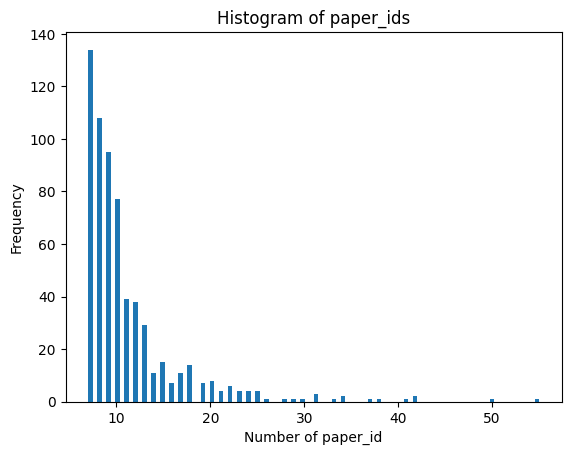

In [118]:
import matplotlib.pyplot as plt

# "paper_id" 열의 길이(데이터의 수)를 히스토그램으로 그리기
#filtered_id_lengths = [length for length in id_lengths if length > 6]
plt.hist(filtered_id_lengths, bins = 100)
plt.title('Histogram of paper_ids')
plt.xlabel('Number of paper_id')
plt.ylabel('Frequency')
plt.show()

In [192]:
# 명목형 변수 정수 인코딩
label_encoder = LabelEncoder()
base_df['source'] = label_encoder.fit_transform(base_df['source'])
source_hist = base_df.groupby(['author_id'])['source'].apply(list).reset_index()
source_hist['source'] = source_hist['source'].apply(lambda x: list(set(x)))
source_hist.sample(5)

,author_id,source
5530,12791874300,[6]
22330,57213668794,"[1, 6]"
4300,7801508455,"[9, 11, 6]"
17170,56910252000,"[11, 12]"
12174,54890798600,[11]


In [121]:
# 연속형 변수 스케일링
scaler = MinMaxScaler()
base_df['year'] = base_df['year'].astype(int)
base_df['paper_age'] = scaler.fit_transform(base_df['year'].values.reshape(-1, 1))
age_hist = base_df.groupby(['author_id'])['paper_age'].apply(list).reset_index()
age_hist.head(2)

,author_id,paper_age
0,6503876395,[0.0]
1,6503877646,"[0.4210526315789451, 0.47368421052631504]"


In [122]:
# 연속형 변수 스케일링
scaler = MinMaxScaler()
base_df['citation'] = base_df['citation'].astype(int)
base_df['citation'] = scaler.fit_transform(base_df['citation'].values.reshape(-1, 1))
citation_hist = base_df.groupby(['author_id'])['citation'].apply(list).reset_index()
citation_hist.head()

,author_id,citation
0,6503876395,[0.004935459377372818]
1,6503877646,"[0.016704631738800303, 0.004935459377372818]"
2,6503897769,[0.014806378132118452]
3,6503925997,[0.0022779043280182236]
4,6503936010,"[0.0007593014426727411, 0.00037965072133637056]"


context-based embedding 1 - BERT, SciBERT

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer_scibert = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [ ]:
#context-based embedding 1 - BERT, SciBERT

def emb_bert(text, tokenizer):
  key_emb = ""
  embs = []
  tokens = tokenizer.tokenize(text)
  for tok in tqdm(tokens):
    key_emb = tokenizer.vocab[tok]
    embs.append(key_emb)
  return embs

keywords = base_df.groupby('author_id')['keywords_'].apply(lambda x: ' '.join(x)).reset_index()
keywords['keywords_'] = keywords['keywords_'].apply(lambda x : emb_bert(x, tokenizer_scibert))

keywords

In [70]:
corpus = base_df.drop_duplicates(subset='paper_id', keep='first')
print(corpus.shape)
paper_id = corpus['paper_id']
print(paper_id)

(15432, 13)
0            1
3            2
4            3
6            4
7            5
         ...  
43194    15429
43201    15430
43204    15431
43206    15432
43209    15433
Name: paper_id, Length: 15432, dtype: int64


context-based embedding 2 - doc2vec

In [124]:
#context-based embedding 2 - doc2vec
corpus = base_df.drop_duplicates(subset='paper_id', keep='first')
corpus['keywords'] = corpus['keywords'].apply(lambda x: x.split("; "))
corpus = corpus[["paper_id", "keywords"]]
corpus = corpus.dropna()
print(corpus.shape)
corpus.tail(3)

(15432, 2)


,paper_id,keywords
43204,15430,"[aviation, pharmaceuticals, regulation, techno..."
43206,15431,"[business angel, exit, financial resources, in..."
43209,15432,"[motivation-opportunity-ability framework, org..."


In [125]:
tagged_corpus_list = []

for index, row in tqdm(corpus.iterrows(), total=len(corpus)):
  text = row['keywords']
  tag = row['paper_id']
  tagged_corpus_list.append(TaggedDocument(tags=[tag], words=text))

print('논문의 수 :', len(tagged_corpus_list))

100%|██████████| 15432/15432 [00:00<00:00, 23224.16it/s]

논문의 수 : 15432


In [175]:
#Doc2Vec 학습
model = doc2vec.Doc2Vec(vector_size=1, alpha=0.025, min_alpha=0.025, workers=8, window=8)

# Vocabulary 빌드
model.build_vocab(tagged_corpus_list)
#print(f"Tag Size: {len(model.docvecs.doctags.keys())}", end=' / ')

# Doc2Vec 학습
model.train(tagged_corpus_list, total_examples=model.corpus_count, epochs=50)

# 모델 저장
model.save('keywords_1d.doc2vec')

In [176]:
#%cd doc2vec
vocabulary = list(model.wv.index_to_key)
print("Vocabulary:")
for word in vocabulary[:10]:
    print(word)

Vocabulary:
innovation
technology transfer
china
patents
open innovation
technological innovation
entrepreneurship
r&d
sustainability
innovation policy


In [177]:
similar_doc = model.docvecs.most_similar(1)
print(similar_doc)

[(9936, 1.0), (9934, 1.0), (9940, 1.0), (9939, 1.0), (9938, 1.0), (9937, 1.0), (9942, 1.0), (9930, 1.0), (9932, 1.0), (9943, 1.0)]


In [178]:
#1번 논문의 임베딩
model.docvecs[1]

array([0.24068373], dtype=float32)

In [184]:
doc_embeddings = []
paper_ids = []

for doc_id in range(1, len(corpus) + 1):
    paper_ids.append(doc_id)
    doc_embedding = model.dv[doc_id]
    doc_embeddings.append(doc_embedding)

# DataFrame으로 변환
data = {'paper_id': paper_ids, 'doc2vec': doc_embeddings}
df = pd.DataFrame(data)
df

,paper_id,doc2vec
0,1,[0.24068373]
1,2,[-0.0018035509]
2,3,[0.24186914]
3,4,[0.3566116]
4,5,[0.43833438]
...,...,...
15427,15428,[0.31285062]
15428,15429,[-0.09580643]
15429,15430,[0.36584952]
15430,15431,[0.49413013]


In [185]:
df['doc2vec'] = df['doc2vec'].astype(float)
df

,paper_id,doc2vec
0,1,0.240684
1,2,-0.001804
2,3,0.241869
3,4,0.356612
4,5,0.438334
...,...,...
15427,15428,0.312851
15428,15429,-0.095806
15429,15430,0.365850
15430,15431,0.494130


In [146]:
df['doc_emb_m'] = df['doc2vec_embedding'].apply(lambda x: np.mean(x, axis=0))
df['doc_emb_s'] = df['doc2vec_embedding'].apply(lambda x: np.sum(x, axis=0))
df

,paper_id,doc2vec_embedding,doc_emb_m,doc_emb_s
0,1,"[-0.16338906, -0.09241974, 0.0067125503, 0.040...",0.003812,1.143567
1,2,"[-0.0006986317, 0.04648378, -0.025559062, 0.08...",0.000591,0.177231
2,3,"[0.04991681, -0.030519081, -0.00023159268, -0....",0.000116,0.034773
3,4,"[-0.00036991, 0.0005857905, -0.0018949214, 0.0...",0.000041,0.012387
4,5,"[0.08658479, 0.07478007, 0.12653302, 0.1127374...",-0.007126,-2.137730
...,...,...,...,...
15427,15428,"[-0.06866682, 0.045954183, -0.022422474, -0.19...",-0.004852,-1.455637
15428,15429,"[-0.07635487, 0.087850206, 0.009593916, -0.072...",0.004312,1.293571
15429,15430,"[-0.060306698, 0.020577285, 0.057892404, -0.21...",0.010324,3.097109
15430,15431,"[-0.03208177, 0.1003109, 0.0068312297, 0.05531...",0.004430,1.328984


In [186]:
base_df = pd.merge(base_df, df, on = 'paper_id', how = 'left')
print(base_df.shape)
base_df.sample(3)

(43212, 19)


,old_paper_id,paper_id,author_id,author_type,title,year,source,citation,abstract,keywords,keywords_,write,paper_age,doc2vec_embedding_x,doc2vec_embedding_y,doc_emb_m,doc_emb_s,doc2vec_x,doc2vec_y
27981,11405,10811,57533601600,5,internet adoption and financial development in...,2020,11,0.008732,information and communications technology ict ...,economic freedom; financial development; human...,economic freedom financial development human c...,1,0.894737,"[-0.044431612, 0.014842663, 0.06326422, 0.0807...","[-0.044431612, 0.014842663, 0.06326422, 0.0807...",0.000456,0.136915,[0.0871951],0.087195
997,9230,495,7006258746,5,human capital heterogeneity collaborative rela...,2004,9,0.039484,in this paper we compare the publication outco...,alliance; collaboration; human capital; knowle...,alliance collaboration human capital knowledge...,1,0.052632,"[-0.15876544, 0.14636709, 0.07240024, 0.162385...","[-0.15876544, 0.14636709, 0.07240024, 0.162385...",-0.000327,-0.098065,[0.3209306],0.320931
43118,16291,15409,57201376672,3,the drivers of the digital transformation in t...,2022,13,0.000759,in recent years driven by the spread of the co...,digital transformation; digitalisation; health...,digital transformation digitalisation healthca...,1,1.000000,"[-0.0017136047, 0.14376356, -0.031006461, 0.06...","[-0.0017136047, 0.14376356, -0.031006461, 0.06...",-0.001421,-0.426289,[0.9289418],0.928942


In [187]:
keywords = base_df.groupby(['author_id'])['doc2vec_y'].apply(list).reset_index()
keywords

,author_id,doc2vec_y
0,6503876395,[0.5925654172897339]
1,6503877646,"[-0.21806655824184418, 1.016183853149414]"
2,6503897769,[0.5237812995910645]
3,6503925997,[0.5780498385429382]
4,6503936010,"[0.8798040747642517, 0.3966626226902008]"
...,...,...
25954,58029375900,[0.477058470249176]
25955,58030387100,[0.477058470249176]
25956,58030505000,[0.7352867722511292]
25957,58032445800,[0.8444942831993103]


Embedding합치기

In [193]:
#input_embedding만들기

input_embedding = keywords[['author_id']].drop_duplicates()
#input_embedding = pd.merge(input_embedding, cont_emb, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, paper_ids, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, source_hist, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, age_hist, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, citation_hist, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, keywords, on = 'author_id', how = 'left')

input_embedding

,author_id,paper_id,source,paper_age,citation,doc2vec_y
0,6503876395,[66],[3],[0.0],[0.004935459377372818],[0.5925654172897339]
1,6503877646,"[3886, 4758]","[9, 12]","[0.4210526315789451, 0.47368421052631504]","[0.016704631738800303, 0.004935459377372818]","[-0.21806655824184418, 1.016183853149414]"
2,6503897769,[641],[13],[0.05263157894736992],[0.014806378132118452],[0.5237812995910645]
3,6503925997,[906],[11],[0.10526315789473983],[0.0022779043280182236],[0.5780498385429382]
4,6503936010,"[9804, 12321]",[11],"[0.8421052631578902, 0.9473684210526301]","[0.0007593014426727411, 0.00037965072133637056]","[0.8798040747642517, 0.3966626226902008]"
...,...,...,...,...,...,...
25954,58029375900,[14035],[8],[1.0],[0.0011389521640091118],[0.477058470249176]
25955,58030387100,[14035],[8],[1.0],[0.0011389521640091118],[0.477058470249176]
25956,58030505000,[13408],[0],[1.0],[0.0],[0.7352867722511292]
25957,58032445800,[15380],[13],[1.0],[0.0],[0.8444942831993103]


In [ ]:
#과거데이터 만들기-1
input_embedding_d_1 = input_embedding[['author_id']].drop_duplicates()
input_embedding_d_1['write_hist'] = input_embedding['paper_id'].apply(lambda x : x[:-1])

input_embedding_d_1['source'] = input_embedding['source'].apply(lambda x : x[:-1])
input_embedding_d_1['paper_age'] = input_embedding['paper_age'].apply(lambda x : x[:-1])
input_embedding_d_1['citation'] = input_embedding['citation'].apply(lambda x : x[:-1])

#predict_labels만들기 (write_hist의 마지막 값)
input_embedding_d_1['predict_labels'] = input_embedding['paper_id'].apply(lambda x : x[-1])

#print(input_embedding.shape)
input_embedding_d_1.tail(3)

,author_id,write_hist,source,paper_age,citation,predict_labels
25956,57217486655,[],[],[],[],15432
25957,55768922000,[],[],[],[],15432
25958,57188726348,[],[],[],[],15433


In [ ]:
input_embedding_dd = input_embedding_d_1[input_embedding_d_1['write_hist'].apply(lambda x: bool(x))]
#input_embedding_dd.to_csv('input_embedding_dd.csv', index=False)
print(input_embedding_dd.shape)
input_embedding_dd.tail(3)

(6675, 6)


,author_id,write_hist,source,paper_age,citation,predict_labels
25745,57202199330,[15293],[13],[1.0],[0.0022779043280182236],15370
25778,56982304200,[15318],[13],[1.0],[0.0],15429
25807,57208108972,[15338],[13],[1.0],[0.0],15389


In [196]:
#과거데이터 만들기_2
input_embedding_d_2 = input_embedding[['author_id']].drop_duplicates()
input_embedding_d_2['write_hist'] = input_embedding['paper_id'].apply(lambda x : x[:-1])

input_embedding_d_2['source'] = input_embedding['source']
input_embedding_d_2['paper_age'] = input_embedding['paper_age'].apply(lambda x : x[:-1])
input_embedding_d_2['citation'] = input_embedding['citation'].apply(lambda x : x[:-1])
input_embedding_d_2['keywords'] = input_embedding['doc2vec_y']

#predict_labels만들기 (write_hist의 마지막 값)
input_embedding_d_2['predict_labels'] = input_embedding['paper_id'].apply(lambda x : x[-1])

#print(input_embedding.shape)
input_embedding_d_2

,author_id,write_hist,source,paper_age,citation,keywords,predict_labels
0,6503876395,[],[3],[],[],[0.5925654172897339],66
1,6503877646,[3886],"[9, 12]",[0.4210526315789451],[0.016704631738800303],"[-0.21806655824184418, 1.016183853149414]",4758
2,6503897769,[],[13],[],[],[0.5237812995910645],641
3,6503925997,[],[11],[],[],[0.5780498385429382],906
4,6503936010,[9804],[11],[0.8421052631578902],[0.0007593014426727411],"[0.8798040747642517, 0.3966626226902008]",12321
...,...,...,...,...,...,...,...
25954,58029375900,[],[8],[],[],[0.477058470249176],14035
25955,58030387100,[],[8],[],[],[0.477058470249176],14035
25956,58030505000,[],[0],[],[],[0.7352867722511292],13408
25957,58032445800,[],[13],[],[],[0.8444942831993103],15380


In [ ]:
input_embedding_dd = input_embedding_d_2[input_embedding_d_2['write_hist'].apply(lambda x: bool(x))]
#input_embedding_dd.to_csv('input_embedding_dd.csv', index=False)
print(input_embedding_dd.shape)
input_embedding_dd.tail(3)

(6675, 7)


,author_id,write_hist,source,paper_age,citation,keywords,predict_labels
25738,57865641400,[13477],"[0, 13]",[1.0],[0.0],"[7366, 14471, 3221, 4684, 4031, 3019, 2653, 63...",15424
25763,57874921300,[7783],"[0, 0]",[0.7368421052631504],[0.0018982536066818527],"[2449, 2832, 2968, 3014, 1997, 5903, 2964, 900...",9357
25893,57955355500,[13413],"[0, 0]",[1.0],[0.0],"[2522, 17258, 2539, 2522, 17258, 2539, 21553, ...",13456


In [197]:
train_data, test_data = train_test_split(input_embedding_d_2, test_size=0.2, random_state=1234) #random_state
print(train_data.shape)  #(20767, 6)
print(test_data.shape)   #(5192, 6)

(20767, 7)
(5192, 7)


In [ ]:
train_data, test_data = train_test_split(input_embedding_dd, test_size=0.2, random_state=1234) #random_state
print(train_data.shape)  #(5340, 7)
print(test_data.shape)   #(1335, 7)

(5340, 7)
(1335, 7)


In [157]:
train_data.sample(2)

,author_id,write_hist,source,paper_age,citation,keywords,predict_labels
25033,57442487200,[],[9],[],[],[-0.00022764226014260203],14120
16133,56415446900,[],[11],[],[],[-0.0012944291811436415],7512


In [158]:
test_data.sample(2)

,author_id,write_hist,source,paper_age,citation,keywords,predict_labels
24535,57253293200,[],[12],[],[],[0.00014655654376838356],12926
24243,57225461391,[],[11],[],[],[-0.0009706158307380974],8979


In [198]:
print(train_data.iloc[35])

author_id                                         55813626200
write_hist                                            [11410]
source                                                    [0]
paper_age                                [0.9473684210526301]
citation                               [0.006074411541381929]
keywords          [-0.06516623497009277, -0.5508178472518921]
predict_labels                                          13234
Name: 14271, dtype: object


Model

In [160]:
#들어온 embedding값을 평균내는 클래스
class MaskedEmbeddingsAggregatorLayer(keras.layers.Layer):
  def __init__(self, agg_mode = 'mean', **kwargs):
    super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)
    self.agg_mode = agg_mode

  @tf.function
  def call(self, inputs, mask = None):  #feedforward
    masked_embeddings = tf.ragged.boolean_mask(inputs, mask)  #입력 임베딩 masking
    #print("masked_embeddings:", masked_embeddings)
    aggregated = tf.reduce_mean(inputs, axis = 1)  #평균
    print("aggregated:", aggregated)
    return aggregated

  def get_config(self):
    return {'agg_mode' : self.agg_mode}


#L2NormLayer적용하는 클래스
class L2NormLayer(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(L2NormLayer, self).__init__(**kwargs)

  @tf.function
  def call(self, inputs, mask = None):
    if mask is None:  #mask가 none이 아니면 mask 적용
      inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()

    return tf.math.l2_normalize(inputs, axis = -1)

  def compute_mask(self, inputs, mask):  #mask반환하기 위해서
    #print(mask)
    return mask

Candidate generation
~~~python
INPUT_LIST: ['write_hist', 'paper_age', 'source', 'citation']
input_shape: Tensor("IteratorGetNext:0", shape=(20767, 54), dtype=int32)
embedding_out_1: Tensor("candidate_generation/embedding/embedding_lookup/Identity_1:0", shape=(20767, 54, 16), dtype=float32)
avg_features: Tensor("candidate_generation/masked_embeddings_aggregator_layer/PartitionedCall:0", shape=(20767, 16), dtype=float32)
embedding_out_2: Tensor("candidate_generation/embedding/embedding_lookup_1/Identity_1:0", shape=(20767, 54, 16), dtype=float32)
avg_features: Tensor("candidate_generation/masked_embeddings_aggregator_layer/PartitionedCall_1:0", shape=(20767, 16), dtype=float32)
embedding_out_3: Tensor("candidate_generation/embedding/embedding_lookup_2/Identity_1:0", shape=(20767, 55, 16), dtype=float32)
avg_features: Tensor("candidate_generation/masked_embeddings_aggregator_layer/PartitionedCall_2:0", shape=(20767, 16), dtype=float32)
embedding_out_4: Tensor("candidate_generation/embedding/embedding_lookup_3/Identity_1:0", shape=(20767, 54, 16), dtype=float32)
avg_features: Tensor("candidate_generation/masked_embeddings_aggregator_layer/PartitionedCall_3:0", shape=(20767, 16), dtype=float32)
concat_inputs: (20767, 64)
dense_features_1024: Tensor("candidate_generation/dense/BiasAdd:0", shape=(20767, 1024), dtype=float32)
dense_features_512: Tensor("candidate_generation/dense_1/BiasAdd:0", shape=(20767, 512), dtype=float32)
dense_features_256: Tensor("candidate_generation/dense_2/BiasAdd:0", shape=(20767, 256), dtype=float32)
OUTPUTS: (20767, 15434)
~~~

In [161]:
NUM_CLASSES = len(base_df['paper_id'].unique()) + 2   #base_df['paper_id'].max()+2
NUM_CLASSES  #15434

15434

In [162]:
class CandidateGeneration(keras.Model):
  def __init__(self, inputs, embedding_dims):  #input과 embedding 차원을 받음
    super(CandidateGeneration, self).__init__()

    self.inputs = inputs
    self.embedding_dims = embedding_dims

    #input받은걸 4개로 나눔
    self.input_watch_hist, self.input_watch_hist_time, self.input_search_hist, self.input_example_age, self.input_keywords = self.inputs

    #embedding layer, aggregation layer 설정
    self.feature_embeddings = keras.layers.Embedding(input_dim = NUM_CLASSES, output_dim = embedding_dims, mask_zero = True, trainable = True)
    self.avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode = 'mean')

    #dense layer설정
    self.dense_layer_list = [keras.layers.Dense(units = i) for i in config.layers]
    self.dense_output = keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

    #배치정규화
    self.batch_norm_layers = [keras.layers.BatchNormalization() for _ in range(3)]

  def call(self, inputs):
    input_watch_hist, input_watch_hist_time, input_search_hist, input_example_age, input_keywords = inputs
    print("input_shape:", input_watch_hist)

    avg_features = self.embeddings(input_watch_hist)
    avg_watches = self.embeddings(input_watch_hist_time)
    avg_searches = self.embeddings(input_search_hist)      #shape=(5340, 16)
    avg_example_age = self.embeddings(input_example_age)   #shape=(5340, 16)
    avg_keywords = self.embeddings(input_keywords)
    print("avg_keywords:", avg_keywords)


    #임베딩 합치기
    concat_inputs = keras.layers.Concatenate(axis = 1)([avg_features, avg_watches, avg_searches, avg_example_age, avg_keywords])
    print("concat_inputs:", concat_inputs.shape)
    results = concat_inputs   #shape=(5340, 64)

    #dense layer, batch normalization layer-> neural network통과
    for dense_layer, batch_norm_layer in zip(self.dense_layer_list, self.batch_norm_layers):
      dense_features = dense_layer(results)
      print("dense_features:", dense_features)
      dense_relu = keras.layers.ReLU()(dense_features)
      dense_batch_norm = batch_norm_layer(dense_relu)
      results = dense_batch_norm
      print("results:",results)

    outputs = self.dense_output(results)
    print("outputs:", outputs)
    return outputs

  def embeddings(self, input_feature):
    #print("input_feature_in_emb:", input_feature)
    embeddings = self.feature_embeddings(input_feature)
    print("embedding_out:", embeddings)
    l2_norm_features = L2NormLayer()(embeddings)
    avg_features = self.avg_embeddings(l2_norm_features)
    print("avg_features:", avg_features)

    return avg_features

In [200]:
config = {
    'epochs': 100,
    'top_k':10,
    'lr' : 0.001,
    'embedding_dims' : 16,
    'dense_units' : 64,
    'layers': [1024, 512, 256]
}

config = Box(config)

#input선언 및 초기화
input_watch_hist = keras.layers.Input(shape = (None,))
input_watch_hist_time = keras.layers.Input(shape = (None,))
input_search_hist = keras.layers.Input(shape = (None,))
input_example_age = keras.layers.Input(shape = (None,))
input_keywords = keras.layers.Input(shape = (None,))

#초기화 해서 input list에 넣어줌
inputs = [input_watch_hist, input_watch_hist_time, input_search_hist, input_example_age, input_keywords]

model = CandidateGeneration(inputs, config.embedding_dims)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = config.lr),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

batch_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit([sequence.pad_sequences(train_data['write_hist']),
                     sequence.pad_sequences(train_data['paper_age'], dtype = float),
                     sequence.pad_sequences(train_data['source']),
                     sequence.pad_sequences(train_data['citation'], dtype = float),
                     sequence.pad_sequences(train_data['keywords'])],
                    train_data['predict_labels'].values,
                    steps_per_epoch = 100, epochs = config.epochs, callbacks=[early_stopping] )#batch_size = batch_size, )

Epoch 1/100
input_shape: Tensor("IteratorGetNext:0", shape=(None, 54), dtype=int32)
embedding_out: Tensor("candidate_generation_4/embedding_4/embedding_lookup/Identity_1:0", shape=(None, 54, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avg_features: Tensor("candidate_generation_4/masked_embeddings_aggregator_layer_4/PartitionedCall:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_4/embedding_4/embedding_lookup_1/Identity_1:0", shape=(None, 54, 16), dtype=float32)
avg_features: Tensor("candidate_generation_4/masked_embeddings_aggregator_layer_4/PartitionedCall_1:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_4/embedding_4/embedding_lookup_2/Identity_1:0", shape=(None, 10, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avg_features: Tensor("candidate_generation_4/masked_embeddings_aggregator_layer_4/PartitionedCall_2:0", shape=(None, 16), dtype=float32

In [ ]:
loss = pd.DataFrame.from_dict(history.history)
display(loss)

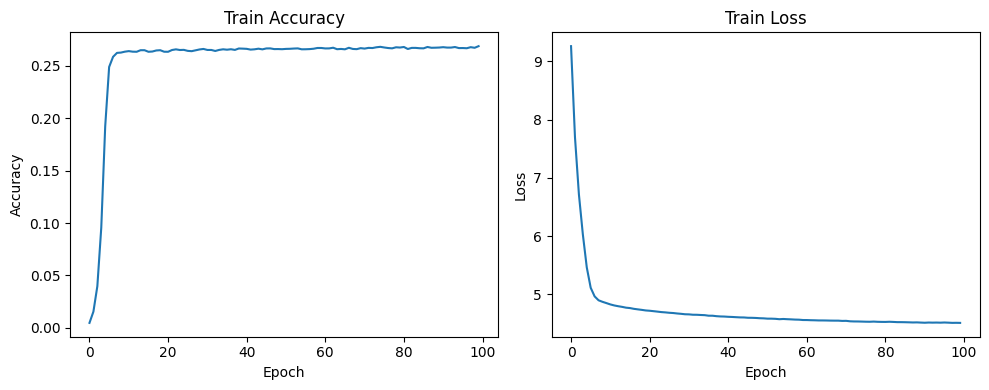

In [172]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(history.history['acc'])
ax[0].set_title('Train Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].set_title('Train Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')

fig.tight_layout()
plt.show()

In [ ]:
model.save('candidate_0906_1540', save_format="tf")

In [201]:
# 테스트 데이터 준비 (예시)
#test_inputs = [test_data['write_hist'], test_data['paper_age'], test_data['source'], test_data['citation']]
#test_labels = test_data['predict_labels'].values

# 모델 평가
loss, accuracy = model.evaluate([sequence.pad_sequences(test_data['write_hist']),
                                 sequence.pad_sequences(test_data['paper_age'], dtype = float),
                                 sequence.pad_sequences(test_data['source']),
                                 sequence.pad_sequences(test_data['citation'], dtype = float),
                                 sequence.pad_sequences(test_data['keywords'])],
                                 test_data['predict_labels'].values, )

print(" Loss:",loss,"\n","Accuracy:", accuracy)

input_shape: Tensor("IteratorGetNext:0", shape=(None, 30), dtype=int32)
embedding_out: Tensor("candidate_generation_4/embedding_4/embedding_lookup/Identity_1:0", shape=(None, 30, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avg_features: Tensor("candidate_generation_4/masked_embeddings_aggregator_layer_4/PartitionedCall:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_4/embedding_4/embedding_lookup_1/Identity_1:0", shape=(None, 30, 16), dtype=float32)
avg_features: Tensor("candidate_generation_4/masked_embeddings_aggregator_layer_4/PartitionedCall_1:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_4/embedding_4/embedding_lookup_2/Identity_1:0", shape=(None, 8, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avg_features: Tensor("candidate_generation_4/masked_embeddings_aggregator_layer_4/PartitionedCall_2:0", shape=(None, 16), dtype=float32)
embedding_o

Feature = ["title", "abstract", "kewords"]

In [ ]:
base_df.head(3)

,old_paper_id,paper_id,author_id,author_type,title,year,source,citation,abstract,keywords,keywords_,write,paper_age
0,1856,1,6602364830,3,a multilevel analysis of factors influencing t...,2003,0,0.014047,the internet is an outcome of the convergence ...,banking industry; electronic commerce; multile...,banking industry electronic commerce multileve...,1,0.0
1,1856,1,55662922800,2,a multilevel analysis of factors influencing t...,2003,0,0.014047,the internet is an outcome of the convergence ...,banking industry; electronic commerce; multile...,banking industry electronic commerce multileve...,1,0.0
2,1856,1,7103126830,1,a multilevel analysis of factors influencing t...,2003,0,0.014047,the internet is an outcome of the convergence ...,banking industry; electronic commerce; multile...,banking industry electronic commerce multileve...,1,0.0


In [ ]:
#base_df['features'] = base_df['title'] + ' ' + base_df['abstract'] + ' ' + base_df['keywords_']
base_df['features'] = base_df['title'] + ' ' + base_df['keywords_']
base_df['features'][0]

'a multilevel analysis of factors influencing the adoption of internet banking banking industry electronic commerce multilevel analysis of technology adoption product and process innovations in user industries strategic change technological change technological innovation'

In [ ]:
#context-based embedding
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def emb_bert(text):
  key_emb = ""
  embs = []
  tokens = tokenizer.tokenize(text)
  for tok in tokens:
    key_emb = tokenizer.vocab[tok]
    embs.append(key_emb)
  return embs

features = base_df.groupby('author_id')['features'].apply(lambda x: ' '.join(x)).reset_index()
features['features'] = features['features'].apply(lambda x : emb_bert(x))

features

,author_id,features
0,6503876395,"[8144, 6194, 1999, 9677, 12906, 1997, 15488, 2..."
1,6503877646,"[5278, 1996, 3193, 1997, 3612, 2373, 2458, 206..."
2,6503897769,"[1996, 3466, 1997, 4816, 6236, 2006, 2235, 282..."
3,6503925997,"[2112, 28775, 4502, 7062, 4013, 26745, 10074, ..."
4,6503936010,"[24155, 1997, 15836, 3930, 1999, 1996, 8174, 3..."
...,...,...
25954,58029375900,"[9859, 2005, 9099, 10521, 6895, 28296, 5649, 2..."
25955,58030387100,"[9859, 2005, 9099, 10521, 6895, 28296, 5649, 2..."
25956,58030505000,"[8536, 17547, 2005, 6605, 4800, 26266, 2326, 3..."
25957,58032445800,"[13296, 3716, 6125, 3945, 1998, 4654, 24759, 6..."


In [ ]:
#input_embedding만들기

input_embedding = keywords[['author_id']].drop_duplicates()
#input_embedding = pd.merge(input_embedding, cont_emb, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, paper_ids, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, source_hist, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, age_hist, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, citation_hist, on = 'author_id', how = 'left')
input_embedding = pd.merge(input_embedding, features, on = 'author_id', how = 'left')

input_embedding

,author_id,paper_id,source,paper_age,citation,features
0,6503876395,[66],[3],[0.0],[0.004935459377372818],"[8144, 6194, 1999, 9677, 12906, 1997, 15488, 2..."
1,6503877646,"[3886, 4758]","[9, 12]","[0.4210526315789451, 0.47368421052631504]","[0.016704631738800303, 0.004935459377372818]","[5278, 1996, 3193, 1997, 3612, 2373, 2458, 206..."
2,6503897769,[641],[13],[0.05263157894736992],[0.014806378132118452],"[1996, 3466, 1997, 4816, 6236, 2006, 2235, 282..."
3,6503925997,[906],[11],[0.10526315789473983],[0.0022779043280182236],"[2112, 28775, 4502, 7062, 4013, 26745, 10074, ..."
4,6503936010,"[9805, 12322]","[11, 11]","[0.8421052631578902, 0.9473684210526301]","[0.0007593014426727411, 0.00037965072133637056]","[24155, 1997, 15836, 3930, 1999, 1996, 8174, 3..."
...,...,...,...,...,...,...
25954,58029375900,[14036],[8],[1.0],[0.0011389521640091118],"[9859, 2005, 9099, 10521, 6895, 28296, 5649, 2..."
25955,58030387100,[14036],[8],[1.0],[0.0011389521640091118],"[9859, 2005, 9099, 10521, 6895, 28296, 5649, 2..."
25956,58030505000,[13409],[0],[1.0],[0.0],"[8536, 17547, 2005, 6605, 4800, 26266, 2326, 3..."
25957,58032445800,[15381],[13],[1.0],[0.0],"[13296, 3716, 6125, 3945, 1998, 4654, 24759, 6..."


In [ ]:
#과거데이터 만들기_2
input_embedding_d_2 = input_embedding[['author_id']].drop_duplicates()
input_embedding_d_2['write_hist'] = input_embedding['paper_id'].apply(lambda x : x[:-1])
input_embedding_d_2['source'] = input_embedding['source']
input_embedding_d_2['paper_age'] = input_embedding['paper_age'].apply(lambda x : x[:-1])
input_embedding_d_2['citation'] = input_embedding['citation'].apply(lambda x : x[:-1])
input_embedding_d_2['features'] = input_embedding['features']

#predict_labels만들기 (write_hist의 마지막 값)
input_embedding_d_2['predict_labels'] = input_embedding['paper_id'].apply(lambda x : x[-1])

#print(input_embedding.shape)
input_embedding_d_2

,author_id,write_hist,source,paper_age,citation,features,predict_labels
0,6503876395,[],[3],[],[],"[8144, 6194, 1999, 9677, 12906, 1997, 15488, 2...",66
1,6503877646,[3886],"[9, 12]",[0.4210526315789451],[0.016704631738800303],"[5278, 1996, 3193, 1997, 3612, 2373, 2458, 206...",4758
2,6503897769,[],[13],[],[],"[1996, 3466, 1997, 4816, 6236, 2006, 2235, 282...",641
3,6503925997,[],[11],[],[],"[2112, 28775, 4502, 7062, 4013, 26745, 10074, ...",906
4,6503936010,[9805],"[11, 11]",[0.8421052631578902],[0.0007593014426727411],"[24155, 1997, 15836, 3930, 1999, 1996, 8174, 3...",12322
...,...,...,...,...,...,...,...
25954,58029375900,[],[8],[],[],"[9859, 2005, 9099, 10521, 6895, 28296, 5649, 2...",14036
25955,58030387100,[],[8],[],[],"[9859, 2005, 9099, 10521, 6895, 28296, 5649, 2...",14036
25956,58030505000,[],[0],[],[],"[8536, 17547, 2005, 6605, 4800, 26266, 2326, 3...",13409
25957,58032445800,[],[13],[],[],"[13296, 3716, 6125, 3945, 1998, 4654, 24759, 6...",15381


In [ ]:
train_data, test_data = train_test_split(input_embedding_d_2, test_size=0.2, random_state=1234) #random_state
print(train_data.shape)  #(20767, 6)
print(test_data.shape)   #(5192, 6)

(20767, 7)
(5192, 7)


In [ ]:
NUM_CLASSES = len(input_embedding_d_2['predict_labels'].unique()) + 2   #base_df['paper_id'].max()+2
NUM_CLASSES  #11840

NameError: ignored

In [ ]:
#들어온 embedding값을 평균내는 클래스
class MaskedEmbeddingsAggregatorLayer(keras.layers.Layer):
  def __init__(self, agg_mode = 'mean', **kwargs):
    super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)
    self.agg_mode = agg_mode

  @tf.function
  def call(self, inputs, mask = None):  #feedforward
    masked_embeddings = tf.ragged.boolean_mask(inputs, mask)  #입력 임베딩 masking
    #print("masked_embeddings:", masked_embeddings)
    aggregated = tf.reduce_mean(inputs, axis = 1)  #평균
    print("aggregated:", aggregated)
    return aggregated

  def get_config(self):
    return {'agg_mode' : self.agg_mode}


#L2NormLayer적용하는 클래스
class L2NormLayer(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(L2NormLayer, self).__init__(**kwargs)

  @tf.function
  def call(self, inputs, mask = None):
    if mask is None:  #mask가 none이 아니면 mask 적용
      inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()

    return tf.math.l2_normalize(inputs, axis = -1)

  def compute_mask(self, inputs, mask):  #mask반환하기 위해서
    #print(mask)
    return mask




class CandidateGeneration(keras.Model):
  def __init__(self, inputs, embedding_dims):  #input과 embedding 차원을 받음
    super(CandidateGeneration, self).__init__()

    self.inputs = inputs
    self.embedding_dims = embedding_dims

    #input받은걸 4개로 나눔
    self.input_watch_hist, self.input_watch_hist_time, self.input_search_hist, self.input_example_age, self.input_features = self.inputs

    #embedding layer, aggregation layer 설정
    self.feature_embeddings = keras.layers.Embedding(input_dim = NUM_CLASSES, output_dim = embedding_dims, mask_zero = True, trainable = True)
    self.avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode = 'mean')

    #dense layer설정
    self.dense_layer_list = [keras.layers.Dense(units = i) for i in config.layers]
    self.dense_output = keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

    #배치정규화
    self.batch_norm_layers = [keras.layers.BatchNormalization() for _ in range(3)]
    self.drop_out_layers = [keras.layers.Dropout(0.5) for _ in range(3)]

  def call(self, inputs):
    input_watch_hist, input_watch_hist_time, input_search_hist, input_example_age, input_features = inputs
    print("input_shape:", input_watch_hist)

    avg_watches = self.embeddings(input_watch_hist)
    avg_watch_hist = self.embeddings(input_watch_hist_time)
    avg_searches = self.embeddings(input_search_hist)      #shape=(5340, 16)
    avg_example_age = self.embeddings(input_example_age)   #shape=(5340, 16)
    avg_features = self.embeddings(input_features)
    print("avg_features:", avg_watches)


    #임베딩 합치기
    concat_inputs = keras.layers.Concatenate(axis = 1)([avg_watches, avg_watch_hist, avg_searches, avg_example_age, avg_features])
    print("concat_inputs:", concat_inputs.shape)
    results = concat_inputs   #shape=(5340, 64)

    #dense layer, batch normalization layer-> neural network통과
    for dense_layer, batch_norm_layer in zip(self.dense_layer_list, self.batch_norm_layers):
      dense_features = dense_layer(results)
      print("dense_features:", dense_features)
      dense_relu = keras.layers.ReLU()(dense_features)
      dense_batch_norm = batch_norm_layer(dense_relu)
      results = dense_batch_norm
      print("results:",results)

    outputs = self.dense_output(results)
    print("outputs:", outputs)
    return outputs

  def embeddings(self, input_feature):
    #print("input_feature_in_emb:", input_feature)
    embeddings = self.feature_embeddings(input_feature)
    print("embedding_out:", embeddings)
    l2_norm_features = L2NormLayer()(embeddings)
    avgg_features = self.avg_embeddings(l2_norm_features)

    print("avgg_features:", avgg_features)

    return avgg_features


In [ ]:
config = {
    'epochs': 100,
    'top_k':10,
    'lr' : 0.01,
    'embedding_dims' : 16,
    'dense_units' : 64,
    'layers': [1024, 512, 256]
}

config = Box(config)

#input선언 및 초기화
input_watch_hist = keras.layers.Input(shape = (None,))
input_watch_hist_time = keras.layers.Input(shape = (None,))
input_search_hist = keras.layers.Input(shape = (None,))
input_example_age = keras.layers.Input(shape = (None,))
input_features = keras.layers.Input(shape = (None,))

#초기화 해서 input list에 넣어줌
inputs = [input_watch_hist, input_watch_hist_time, input_search_hist, input_example_age, input_features]

model = CandidateGeneration(inputs, config.embedding_dims)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = config.lr),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

batch_size = 32

history = model.fit([sequence.pad_sequences(train_data['write_hist']),
                     sequence.pad_sequences(train_data['paper_age'], dtype = float),
                     sequence.pad_sequences(train_data['source']),
                     sequence.pad_sequences(train_data['citation'], dtype = float),
                     sequence.pad_sequences(train_data['features'], padding = 'post'),],
                    train_data['predict_labels'].values,
                    steps_per_epoch = 100, epochs = config.epochs, )#batch_size = batch_si

Epoch 1/100
input_shape: Tensor("IteratorGetNext:0", shape=(None, 54), dtype=int32)
embedding_out: Tensor("candidate_generation_32/embedding_32/embedding_lookup/Identity_1:0", shape=(None, 54, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avgg_features: Tensor("candidate_generation_32/masked_embeddings_aggregator_layer_32/PartitionedCall:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_32/embedding_32/embedding_lookup_1/Identity_1:0", shape=(None, 54, 16), dtype=float32)
avgg_features: Tensor("candidate_generation_32/masked_embeddings_aggregator_layer_32/PartitionedCall_1:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_32/embedding_32/embedding_lookup_2/Identity_1:0", shape=(None, 55, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avgg_features: Tensor("candidate_generation_32/masked_embeddings_aggregator_layer_32/PartitionedCall_2:0", shape=(None, 16)

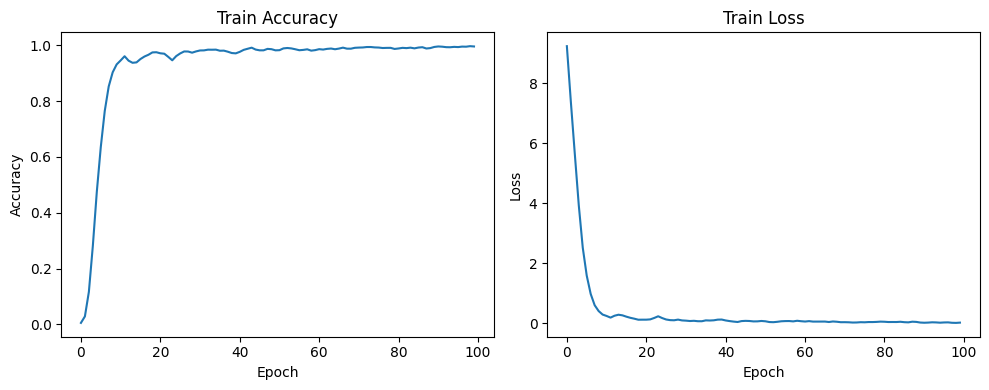

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(history.history['acc'])
ax[0].set_title('Train Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].set_title('Train Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')

fig.tight_layout()
plt.show()

In [ ]:

# 테스트 데이터 준비 (예시)
#test_inputs = [test_data['write_hist'], test_data['paper_age'], test_data['source'], test_data['citation']]
#test_labels = test_data['predict_labels'].values

# 모델 평가
loss, accuracy = model.evaluate([sequence.pad_sequences(test_data['write_hist']),
                                 sequence.pad_sequences(test_data['paper_age'], dtype = float),
                                 sequence.pad_sequences(test_data['source']),
                                 sequence.pad_sequences(test_data['citation'], dtype = float),
                                 sequence.pad_sequences(test_data['features'])],
                                 test_data['predict_labels'].values, )

print(" Loss:",loss,"\n","Accuracy:", accuracy)

input_shape: Tensor("IteratorGetNext:0", shape=(None, 30), dtype=int32)
embedding_out: Tensor("candidate_generation_24/embedding_24/embedding_lookup/Identity_1:0", shape=(None, 30, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avgg_features: Tensor("candidate_generation_24/masked_embeddings_aggregator_layer_24/PartitionedCall:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_24/embedding_24/embedding_lookup_1/Identity_1:0", shape=(None, 30, 16), dtype=float32)
avgg_features: Tensor("candidate_generation_24/masked_embeddings_aggregator_layer_24/PartitionedCall_1:0", shape=(None, 16), dtype=float32)
embedding_out: Tensor("candidate_generation_24/embedding_24/embedding_lookup_2/Identity_1:0", shape=(None, 31, 16), dtype=float32)
aggregated: Tensor("Mean:0", shape=(None, 16), dtype=float32)
avgg_features: Tensor("candidate_generation_24/masked_embeddings_aggregator_layer_24/PartitionedCall_2:0", shape=(None, 16), dtype=floa

In [ ]:
sequence.pad_sequences()